# **Install**

In [ ]:
!pip install flair seqeval pytorch-crf sklearn-crfsuite --quiet

In [ ]:
!pip install --upgrade flair

In [ ]:
!pip install flair[word-embeddings]

# **Import Dataset and Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_path = "/kaggle/input/nerskill/NERSkill.Id.txt"
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence #", "Word", "Tag"], skiprows=1)

df["Sentence #"] = df["Sentence #"].ffill()

sentences = (
    df.groupby("Sentence #", group_keys=False)
    .apply(lambda s: list(zip(s["Word"], s["Tag"])))
    .tolist()
)

train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3, random_state=42)
val_sentences, test_sentences = train_test_split(temp_sentences, test_size=1/3, random_state=42)

<ipython-input-11-f32273d4666c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda s: list(zip(s["Word"], s["Tag"])))


# **Bi-LSTM CRF + FastText**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from collections import defaultdict

In [ ]:
# Load pretrained FastText (Indonesia)
fasttext_embedding = WordEmbeddings('id')

def word_to_vector(word):
    sentence = Sentence(word)
    fasttext_embedding.embed(sentence)
    return sentence[0].embedding.detach().cpu().numpy()  # Output: (300,)

def convert_to_embeddings(sentences):
    return [[word_to_vector(w) for w, _ in sent] for sent in sentences]

X_train_unpad = convert_to_embeddings(train_sentences)
X_val_unpad = convert_to_embeddings(val_sentences)
X_test_unpad = convert_to_embeddings(test_sentences)

MAX_LEN = max(max(len(s) for s in X_train_unpad), max(len(s) for s in X_val_unpad), max(len(s) for s in X_test_unpad))

def pad_sequences(X):
    return np.array([
        np.pad(s, ((0, MAX_LEN - len(s)), (0, 0)), 'constant') for s in X
    ])

X_train = pad_sequences(X_train_unpad)
X_val = pad_sequences(X_val_unpad)
X_test = pad_sequences(X_test_unpad)

print(f"Shape X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")


2025-04-21 06:32:07,225 https://flair.informatik.hu-berlin.de/resources/embeddings/token/id-wiki-fasttext-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpu6w39k3s


100%|██████████| 344M/344M [00:17<00:00, 20.1MB/s] 

2025-04-21 06:32:25,673 copying /tmp/tmpu6w39k3s to cache at /root/.flair/embeddings/id-wiki-fasttext-300d-1M.vectors.npy


2025-04-21 06:32:25,956 removing temp file /tmp/tmpu6w39k3s
2025-04-21 06:32:26,571 https://flair.informatik.hu-berlin.de/resources/embeddings/token/id-wiki-fasttext-300d-1M not found in cache, downloading to /tmp/tmpexm8tesz


100%|██████████| 11.1M/11.1M [00:01<00:00, 9.30MB/s]

2025-04-21 06:32:28,289 copying /tmp/tmpexm8tesz to cache at /root/.flair/embeddings/id-wiki-fasttext-300d-1M
2025-04-21 06:32:28,300 removing temp file /tmp/tmpexm8tesz


Shape X_train: (3007, 633, 300), X_val: (860, 633, 300), X_test: (430, 633, 300)


In [ ]:
tag_to_idx = defaultdict(lambda: len(tag_to_idx))
tag_to_idx["PAD"] = 0

for sent in train_sentences:
    for _, tag in sent:
        _ = tag_to_idx[tag]

idx_to_tag = {i: t for t, i in tag_to_idx.items()}

def convert_labels(sentences):
    return [[tag_to_idx[tag] for _, tag in sent] for sent in sentences]

y_train_unpad = convert_labels(train_sentences)
y_val_unpad = convert_labels(val_sentences)
y_test_unpad = convert_labels(test_sentences)

def pad_labels(y):
    return np.array([
        np.pad(l, (0, MAX_LEN - len(l)), 'constant', constant_values=tag_to_idx["PAD"])
        for l in y
    ])

y_train = pad_labels(y_train_unpad)
y_val = pad_labels(y_val_unpad)
y_test = pad_labels(y_test_unpad)

print(f"Shape y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

Shape y_train: (3007, 633), y_val: (860, 633), y_test: (430, 633)


In [ ]:
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)

In [ ]:
import torchcrf

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)  # Bi-directional output
        self.crf = torchcrf.CRF(num_tags, batch_first=True)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        emissions = self.fc(lstm_out)
        return emissions

    def loss(self, x, y, mask):
        emissions = self.forward(x)
        return -self.crf(emissions, y, mask, reduction="mean")

    def predict(self, x, mask):
        emissions = self.forward(x)
        return self.crf.decode(emissions, mask=mask)


In [ ]:
from itertools import product

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter Grid
hidden_dims = [64, 128]
learning_rates = [0.001]
batch_sizes = [16, 32]

results = []

for hidden_dim, lr, batch_size in product(hidden_dims, learning_rates, batch_sizes):
    print(f"Training BiLSTM-CRF with hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}")

    train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(NERDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    model = BiLSTM_CRF(input_dim=300, hidden_dim=hidden_dim, num_tags=len(tag_to_idx))
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    EPOCHS = 10
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mask = (y_batch != tag_to_idx["PAD"]).to(device) # Exclude PAD label

            optimizer.zero_grad()
            loss = model.loss(X_batch, y_batch, mask)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mask = (y_batch != tag_to_idx["PAD"]).to(device)

            predictions = model.predict(X_batch, mask)

            for i in range(len(y_batch)):
                true_labels = [idx_to_tag[idx.item()] for idx in y_batch[i] if idx.item() != tag_to_idx["PAD"]]
                pred_labels = [idx_to_tag[idx] for idx in predictions[i]]

                y_true.extend(true_labels)
                y_pred.extend(pred_labels)

    val_report = classification_report(y_true, y_pred, output_dict=True)
    val_f1 = val_report['weighted avg']['f1-score']

    results.append({
        'hidden_dim': hidden_dim,
        'lr': lr,
        'batch_size': batch_size,
        'val_f1': val_f1
    })

results_df = pd.DataFrame(results)

print("\nHasil Hyperparameter Tuning (Diurutkan dari validasi f1-score terbaik):")
print(results_df.sort_values(by="val_f1", ascending=False))


Training BiLSTM-CRF with hidden_dim=64, lr=0.001, batch_size=16
Training BiLSTM-CRF with hidden_dim=64, lr=0.001, batch_size=32
Training BiLSTM-CRF with hidden_dim=128, lr=0.001, batch_size=16
Training BiLSTM-CRF with hidden_dim=128, lr=0.001, batch_size=32

Hasil Hyperparameter Tuning (Diurutkan dari validasi f1-score terbaik):
   hidden_dim     lr  batch_size    val_f1
2         128  0.001          16  0.938080
0          64  0.001          16  0.937442
3         128  0.001          32  0.934990
1          64  0.001          32  0.932390


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_DIM = 128
NUM_TAGS = len(tag_to_idx)

batch_size = 16

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(NERDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

model = BiLSTM_CRF(input_dim=300, hidden_dim=HIDDEN_DIM, num_tags=NUM_TAGS)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask = (y_batch != tag_to_idx["PAD"]).to(device)

        optimizer.zero_grad()
        loss = model.loss(X_batch, y_batch, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 46.0059
Epoch 2, Loss: 20.4691
Epoch 3, Loss: 17.3431
Epoch 4, Loss: 15.7935
Epoch 5, Loss: 14.7390
Epoch 6, Loss: 13.8546
Epoch 7, Loss: 13.0312
Epoch 8, Loss: 12.3133
Epoch 9, Loss: 11.5346
Epoch 10, Loss: 11.0216


In [ ]:
test_words = [word for sentence in test_sentences for word, _ in sentence]

In [ ]:
model.eval()
y_true, y_pred = [], []
word_list, pred_list, true_list = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask = (y_batch != tag_to_idx["PAD"]).to(device)

        predictions = model.predict(X_batch, mask)

        for i in range(len(y_batch)):
            sentence = X_batch[i].cpu().numpy()
            true_labels = [idx_to_tag[idx.item()] for idx in y_batch[i] if idx.item() != tag_to_idx["PAD"]]
            pred_labels = [idx_to_tag[idx] for idx in predictions[i]]

            for word_idx in range(len(true_labels)):
                word_list.append(test_words[word_idx])
                true_list.append(true_labels[word_idx])
                pred_list.append(pred_labels[word_idx])

            y_true.extend(true_labels)
            y_pred.extend(pred_labels)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    B-HSkill       0.74      0.68      0.71      1751
    B-SSkill       0.86      0.78      0.82      1116
      B-Tech       0.86      0.90      0.88      1538
    I-HSkill       0.70      0.73      0.71      1159
    I-SSkill       0.82      0.61      0.70       377
      I-Tech       0.72      0.82      0.77       394
           O       0.97      0.97      0.97     34697

    accuracy                           0.94     41032
   macro avg       0.81      0.79      0.79     41032
weighted avg       0.94      0.94      0.94     41032



In [ ]:
from seqeval.metrics import classification_report as seqeval_classification_report
from sklearn.metrics import confusion_matrix

def plot_token_confusion_matrix(y_true, y_pred, idx_to_tag):
    # Get all tags except 'O' and PAD
    tags = [tag for idx, tag in idx_to_tag.items() if tag not in ['O', 'PAD']]

    # Filter out 'O' and PAD tags
    filtered_true = []
    filtered_pred = []
    for t, p in zip(y_true, y_pred):
        if t in tags and p in tags:
            filtered_true.append(t)
            filtered_pred.append(p)

    # Create confusion matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=tags)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=tags, yticklabels=tags)
    plt.title('Token-Level Confusion Matrix (Excluding "O")')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

=== Token-Level Evaluation ===


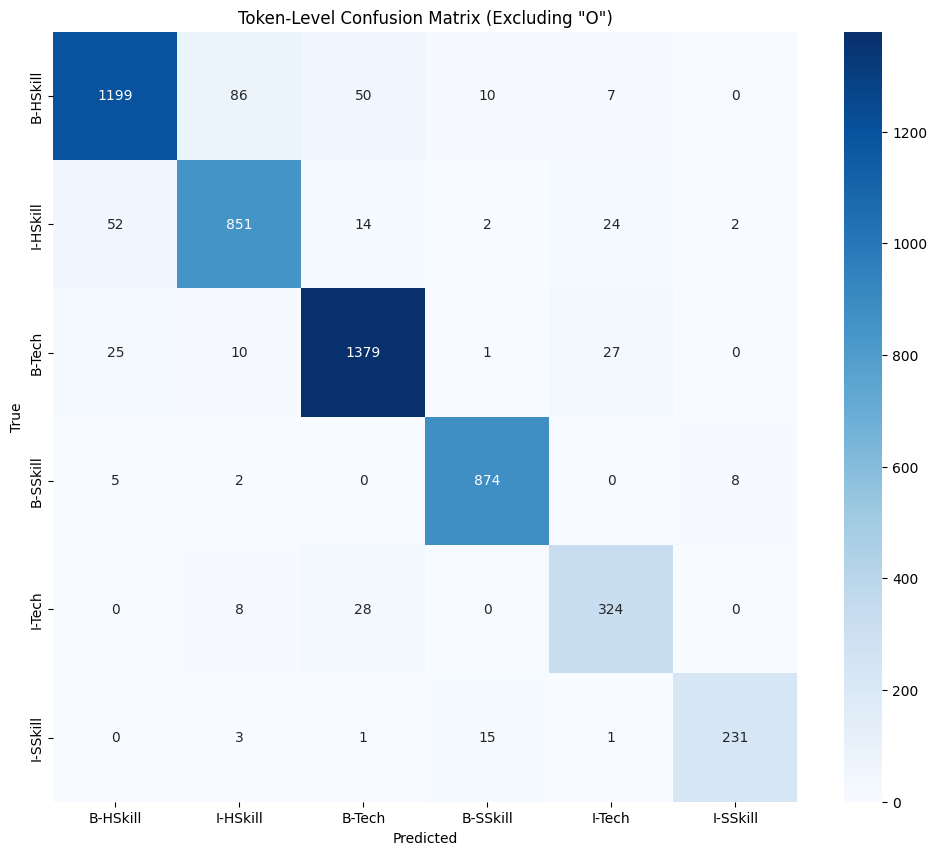

In [ ]:
print("=== Token-Level Evaluation ===")
plot_token_confusion_matrix(true_list, pred_list, idx_to_tag)

In [ ]:
from seqeval.metrics import classification_report as seqeval_classification_report
from collections import defaultdict

def compute_entity_confusion_matrix(true_sentences, pred_sentences, labels):
    """
    Compute a confusion matrix over entity types extracted from token-level IOB sequences.

    Parameters:
      true_sentences: List of lists of true IOB tags (e.g., ["B-PER", "I-PER", "O", ...])
      pred_sentences: List of lists of predicted IOB tags.
      labels: List of entity types (e.g., ["PER", "ORG", "LOC"]) to include.

    Returns:
      A numpy 2D array with shape (len(labels), len(labels)) where rows represent the true
      entity types and columns represent the predicted entity types.
    """
    label_to_index = {label: i for i, label in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for true_seq, pred_seq in zip(true_sentences, pred_sentences):
        for true_tag, pred_tag in zip(true_seq, pred_seq):
            # Skip tokens where either tag is 'O'
            if true_tag == 'O' or pred_tag == 'O':
                continue
            # Extract the entity type (e.g., from "B-PER" get "PER")
            true_type = true_tag.split('-')[1]
            pred_type = pred_tag.split('-')[1]
            if true_type in label_to_index and pred_type in label_to_index:
                cm[label_to_index[true_type], label_to_index[pred_type]] += 1
    return cm

def entity_level_evaluation(test_sentences, y_true_flat, y_pred_flat):
    """
    Enhanced entity-level evaluation with:
    - Complete entity-level confusion matrix (computed with a custom function)
    - Error analysis (missed/spurious entities and type errors)
    - Most common correct/incorrect entities
    """
    # Reconstruct sentences from the flattened lists using sentence lengths.
    true_sentences = []
    pred_sentences = []
    pos = 0
    for sent in test_sentences:
        n = len(sent)
        true_sentences.append(y_true_flat[pos:pos+n])
        pred_sentences.append(y_pred_flat[pos:pos+n])
        pos += n

    # Entity Classification Report (using seqeval)
    print("\n=== Entity-Level Classification Report ===")
    print(seqeval_classification_report(true_sentences, pred_sentences))

    # Entity Confusion Matrix: Compute list of unique entity labels
    entity_labels = sorted(list(set(
        tag.split('-')[1] for sent in true_sentences
        for tag in sent if tag != 'O'
    )))

    ent_cm = compute_entity_confusion_matrix(true_sentences, pred_sentences, entity_labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(ent_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=entity_labels, yticklabels=entity_labels)
    plt.title('Entity-Level Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Error Analysis
    def extract_entities(tags, words):
        """
        Given a list of IOB tags and corresponding words, extract contiguous entities.

        Returns a list of dictionaries with keys:
          'text': list of words
          'type': entity type
          'start': starting index of the entity in the sentence
        """
        entities = []
        current = None
        for i, (tag, word) in enumerate(zip(tags, words)):
            if tag.startswith('B-'):
                if current:
                    entities.append(current)
                current = {'text': [word], 'type': tag[2:], 'start': i}
            elif tag.startswith('I-'):
                if current:
                    current['text'].append(word)
            else:
                if current:
                    entities.append(current)
                    current = None
        if current:
            entities.append(current)
        return entities

    error_analysis = {
        'correct': [],
        'missed': [],
        'spurious': [],
        'type_errors': []
    }

    for sent, true_tags, pred_tags in zip(test_sentences, true_sentences, pred_sentences):
        words = [w for w, _ in sent]
        true_ents = extract_entities(true_tags, words)
        pred_ents = extract_entities(pred_tags, words)

        # Convert to a comparable format: (start_index, entity_text, type)
        true_set = {(e['start'], ' '.join(e['text']), e['type']) for e in true_ents}
        pred_set = {(e['start'], ' '.join(e['text']), e['type']) for e in pred_ents}

        # Correct predictions: entities that exactly match in span and type
        for ent in true_set & pred_set:
            error_analysis['correct'].append(ent)

        # Missed entities (false negatives)
        for ent in true_set - pred_set:
            error_analysis['missed'].append(ent)

        # Spurious entities (false positives)
        for ent in pred_set - true_set:
            error_analysis['spurious'].append(ent)

        # Type errors: same span (start and text), but wrong type
        true_spans = {(s, txt) for s, txt, _ in true_set}
        pred_spans = {(s, txt) for s, txt, _ in pred_set}
        common_spans = true_spans & pred_spans
        for span in common_spans:
            true_type = next(t for s, txt, t in true_set if (s, txt) == span)
            pred_type = next(t for s, txt, t in pred_set if (s, txt) == span)
            if true_type != pred_type:
                error_analysis['type_errors'].append((span[1], true_type, pred_type))

    # Print error statistics
    print("\n=== Error Analysis ===")
    print(f"Correct entities: {len(error_analysis['correct'])}")
    print(f"Missed entities: {len(error_analysis['missed'])}")
    print(f"Spurious entities: {len(error_analysis['spurious'])}")
    print(f"Type errors: {len(error_analysis['type_errors'])}")

    # Show most common errors via DataFrame aggregation
    print("\nTop 10 Missed Entities:")
    print(pd.Series([e[1] for e in error_analysis['missed']]).value_counts().head(10))

    print("\nTop 10 Spurious Entities:")
    print(pd.Series([e[1] for e in error_analysis['spurious']]).value_counts().head(10))

    print("\nTop 10 Type Errors:")
    print(pd.DataFrame(error_analysis['type_errors'],
                     columns=['Text', 'True', 'Predicted'])
          .value_counts().head(10))

    return true_sentences, pred_sentences, error_analysis



=== Entity-Level Classification Report ===
              precision    recall  f1-score   support

      HSkill       0.68      0.63      0.66      1763
      SSkill       0.83      0.75      0.79      1132
        Tech       0.82      0.86      0.84      1540

   micro avg       0.77      0.74      0.75      4435
   macro avg       0.78      0.75      0.76      4435
weighted avg       0.77      0.74      0.75      4435



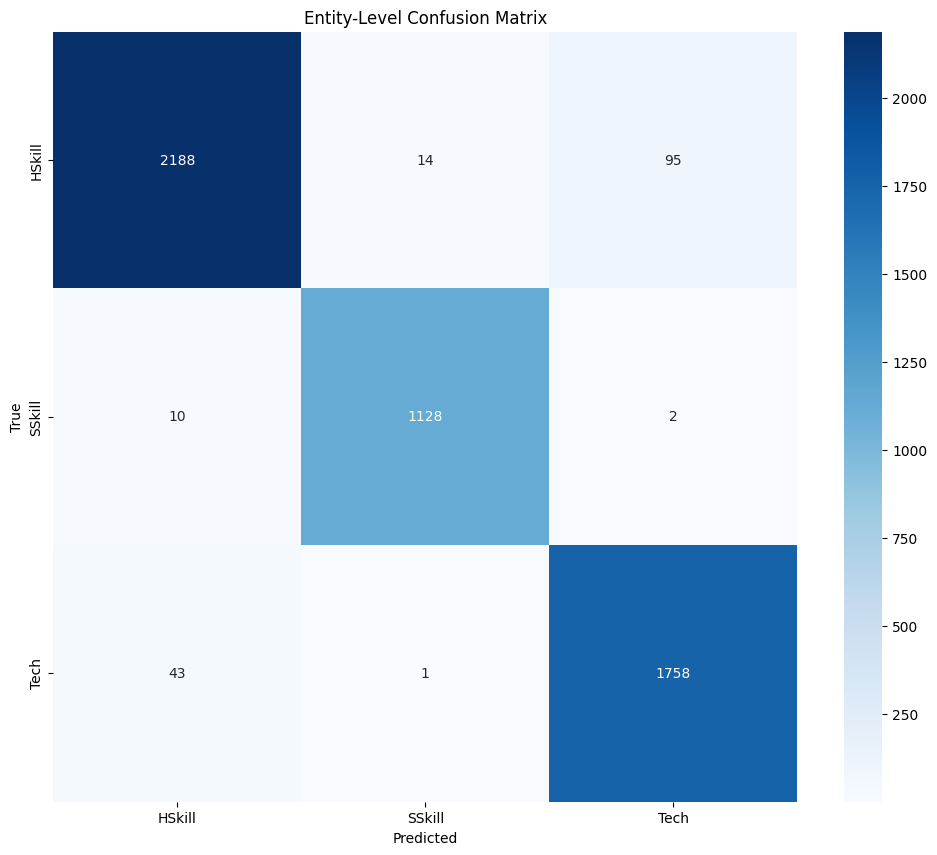


=== Error Analysis ===
Correct entities: 3275
Missed entities: 1130
Spurious entities: 982
Type errors: 69

Top 10 Missed Entities:
tim                17
jaringan           12
IT                 11
C #                10
database            9
SQL                 7
software            7
Programmer          7
perangkat lunak     6
Laravel             6
Name: count, dtype: int64

Top 10 Spurious Entities:
tim                18
C                  13
komunikasi         12
perangkat lunak    11
pemrograman        10
SQL Server          8
jaringan            8
Komputer            7
program             7
database            6
Name: count, dtype: int64

Top 10 Type Errors:
Text             True    Predicted
SQL Server       HSkill  Tech         4
MVC              HSkill  Tech         2
SQL              HSkill  Tech         2
                 Tech    HSkill       2
analisa          HSkill  SSkill       2
TSD              HSkill  Tech         2
Scrum            HSkill  Tech         2
logika      

In [ ]:
true_entities, pred_entities, error_analysis = entity_level_evaluation(test_sentences, true_list, pred_list)

In [ ]:
def prediction_comparison(word_list, true_list, pred_list, idx_to_tag=None):
    token_comparison = pd.DataFrame({
        "Word": word_list,
        "True": true_list,
        "Predicted": pred_list
    })

    # Only keep tokens where the true tag is not 'O'
    filtered_tokens = token_comparison[token_comparison["True"] != "O"]

    # Separate correct and incorrect tokens
    df_correct = filtered_tokens[filtered_tokens["True"] == filtered_tokens["Predicted"]]
    df_incorrect = filtered_tokens[filtered_tokens["True"] != filtered_tokens["Predicted"]]

    print("✅ Correct Token-Level Predictions (First 20):")
    print(df_correct.head(20).to_string(index=False))

    print("\n❌ Incorrect Token-Level Predictions (First 20):")
    print(df_incorrect.head(20).to_string(index=False))

    correct_entities = []
    incorrect_entities = []

    # We'll accumulate tokens that form one entity into current_entity_words,
    # and store the true and predicted entity types.
    current_entity_words = []
    current_entity_true = None
    current_entity_pred = None

    # Helper function to flush the current entity into the proper list.
    def flush_entity():
        nonlocal current_entity_words, current_entity_true, current_entity_pred
        if current_entity_words:
            entity_text = " ".join(current_entity_words)
            if current_entity_true == current_entity_pred:
                correct_entities.append({
                    "Entity": entity_text,
                    "Type": current_entity_true
                })
            else:
                incorrect_entities.append({
                    "Entity": entity_text,
                    "True": current_entity_true,
                    "Predicted": current_entity_pred
                })
            # Reset the current entity.
            current_entity_words = []
            current_entity_true = None
            current_entity_pred = None

    # Iterate over all tokens.
    for word, true_tag, pred_tag in zip(word_list, true_list, pred_list):
        # Skip tokens that are 'O'
        if true_tag == "O":
            flush_entity()  # End any in-progress entity
            continue

        # If it's the beginning of a new entity
        if true_tag.startswith("B-"):
            flush_entity()  # Flush any previous entity first
            current_entity_words = [word]
            # Extract the entity type (e.g., from "B-PER" get "PER")
            current_entity_true = true_tag.split("-")[1]
            current_entity_pred = pred_tag.split("-")[1] if pred_tag != "O" else "O"
        # Continuation of an entity
        elif true_tag.startswith("I-"):
            # If there is an ongoing entity, append the word.
            if current_entity_words:
                current_entity_words.append(word)
            else:
                # If an "I-" appears without a preceding "B-", start new.
                current_entity_words = [word]
                current_entity_true = true_tag.split("-")[1]
                current_entity_pred = pred_tag.split("-")[1] if pred_tag != "O" else "O"
        else:
            # In case there's an unexpected tag format, flush any ongoing entity.
            flush_entity()

    # Flush any entity that remains at the end.
    flush_entity()

    df_entities_correct = pd.DataFrame(correct_entities)
    df_entities_incorrect = pd.DataFrame(incorrect_entities)

    print("\n✅ Correct Entity-Level Predictions (First 10):")
    if not df_entities_correct.empty:
        print(df_entities_correct.head(10).to_string(index=False))
    else:
        print("No correct entity predictions found.")

    print("\n❌ Incorrect Entity-Level Predictions (First 10):")
    if not df_entities_incorrect.empty:
        print(df_entities_incorrect.head(10).to_string(index=False))
    else:
        print("No incorrect entity predictions found.")

    return token_comparison, df_entities_correct, df_entities_incorrect


In [ ]:
token_comparison, df_entities_correct, df_entities_incorrect = prediction_comparison(word_list, true_list, pred_list)

✅ Correct Token-Level Predictions (First 20):
       Word     True Predicted
      React   B-Tech    B-Tech
     Native   I-Tech    I-Tech
development   I-Tech    I-Tech
  integrasi B-HSkill  B-HSkill
     native I-HSkill  I-HSkill
  libraries I-HSkill  I-HSkill
        git   B-Tech    B-Tech
        ioS   B-Tech    B-Tech
   debuging B-HSkill  B-HSkill
       baik   B-Tech    B-Tech
    tentang B-HSkill  B-HSkill
konfigurasi I-HSkill  I-HSkill
    project   B-Tech    B-Tech
    Android   I-Tech    I-Tech
      party B-SSkill  B-SSkill
         di B-SSkill  B-SSkill
    Jakarta I-SSkill  I-SSkill
      tahun I-HSkill  I-HSkill
      React B-HSkill  B-HSkill
     Native I-HSkill  I-HSkill

❌ Incorrect Token-Level Predictions (First 20):
       Word     True Predicted
development B-HSkill         O
   debuging B-HSkill         O
      tools I-HSkill         O
    Android   B-Tech  I-HSkill
          .   I-Tech         O
 Pendidikan B-SSkill         O
 pengalaman B-HSkill         O
      